In [1]:
#Import libraries for simulation
import tensorflow as tf
import numpy as np
sess = tf.InteractiveSession()

In [2]:
#Imports for visualization
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def staticPlot(u):
    x = np.linspace(0, 2*np.pi, len(u))
    fig, ax = plt.subplots()
    line, = ax.plot(x, u)
    plt.show()

In [3]:
def make_kernel(a):
    """Transform a 2D array into a convolution kernel"""
    a = np.asarray(a)
    print(a.shape)
    a = a.reshape(list(a.shape) + [1,1])
    print(a.shape)
    return tf.constant(a, dtype=1)

def simple_conv(x, k):
    """A simplified 2D convolution operation"""
    print("x=",x)
    x = tf.expand_dims(tf.expand_dims(tf.expand_dims(x, 0), -1),-1)
    #k = tf.expand_dims(x, 0)
    print("x=",x)
    print("k=",k)
    y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
    print("y=",y)
    return y[0, :, 0, 0]

def laplace(x):
    """Compute the 2D laplacian of an array"""
    laplace_k = make_kernel([[0., 0.25, 0.],
                             [0., -0.5, 0.],
                             [0., 0.25, 0.]])
    
    #laplace_k = make_kernel([[0.0, 0.0, 0.0],
    #                       [0.5, -1.0, 0.5],
    #                       [0.0, 0.0, 0.0]])
    
    return simple_conv(x, laplace_k)


u_test = tf.Variable(np.zeros([100],dtype=np.float32))
f = laplace(u_test)

(3, 3)
(3, 3, 1, 1)
x= <tf.Variable 'Variable:0' shape=(100,) dtype=float32_ref>
x= Tensor("ExpandDims_2:0", shape=(1, 100, 1, 1), dtype=float32)
k= Tensor("Const:0", shape=(3, 3, 1, 1), dtype=float32)
y= Tensor("depthwise:0", shape=(1, 100, 1, 1), dtype=float32)


<IPython.core.display.Javascript object>


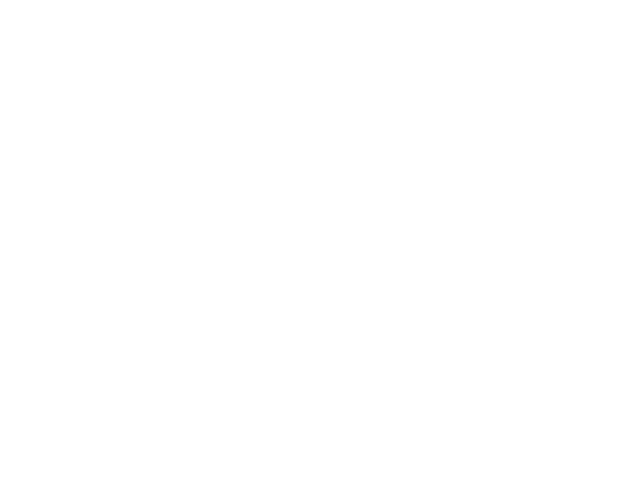

In [4]:
# Initial Conditions -- sine wave
#Error in potential energy for the real solution (i.e. sin(x-t)):
#N = 64     # 0.015625
#N = 65     # 0.015384
#N = 100    # 0.010000
#N = 128    # 0.007812
#N = 129    # 0.007751 
#N = 130    # 0.007692
N = 1025    # 0.000975

#N = 16385  # 0.000061 

# Set everything to zero
u_init = np.zeros([N], dtype=np.float32)
ut_init = np.zeros([N], dtype=np.float32)
x = np.linspace(0.25*np.pi, 10.25*np.pi, N,dtype=np.float32)

#Changing to this interval increases the error (¿For N = 1025, Error = 0.001953?)
#x = np.linspace(0.0, 2.0*np.pi, N,dtype=np.float32)

for i in range(len(u_init)):
    u_init[i] = - np.sin(x[i]) * (x[i] >= 4*np.pi and x[i] < 6*np.pi)
#ut_init = -np.cos(x,dtype=np.float32)

plot = staticPlot(u_init)

In [5]:
# Parameters:
# eps -- time resolution
# damping -- wave damping
eps = tf.placeholder(tf.float32, shape=())
damping = tf.placeholder(tf.float32, shape=())

# Create variables for simulation state
U  = tf.Variable(u_init)
print(U)
Ut = tf.Variable(ut_init)
print(Ut)

# Discretized PDE update rules
U_ = U + eps * Ut
Ut_ = Ut + eps * (laplace(U) - damping * Ut)

# Operation to update the state
step = tf.group(
  U.assign(U_),
  Ut.assign(Ut_))

<tf.Variable 'Variable_1:0' shape=(1025,) dtype=float32_ref>
<tf.Variable 'Variable_2:0' shape=(1025,) dtype=float32_ref>
(3, 3)
(3, 3, 1, 1)
x= <tf.Variable 'Variable_1:0' shape=(1025,) dtype=float32_ref>
x= Tensor("ExpandDims_5:0", shape=(1, 1025, 1, 1), dtype=float32)
k= Tensor("Const_1:0", shape=(3, 3, 1, 1), dtype=float32)
y= Tensor("depthwise_1:0", shape=(1, 1025, 1, 1), dtype=float32)


In [6]:
# Initialize state to initial conditions
tf.global_variables_initializer().run()

#Do simulation
uEvol = []
sinEvol = []
t0=0
tmax=2048
dt = 1000.0*np.pi/float(tmax)
#With spatial resolution of 1025 elements, the error in the potential energy varying the timesteps is, for the 
#real solution:
#2048 timesteps: 0.00097561
#2049 timesteps: 0.00097561
# 129 timesteps: 0.00097553

for t in range(t0,tmax):
    sinEvol.append(np.sin(x-t*dt))
    uEvol.append(U.eval())
    step.run({eps: dt, damping: 0.00})

<IPython.core.display.Javascript object>


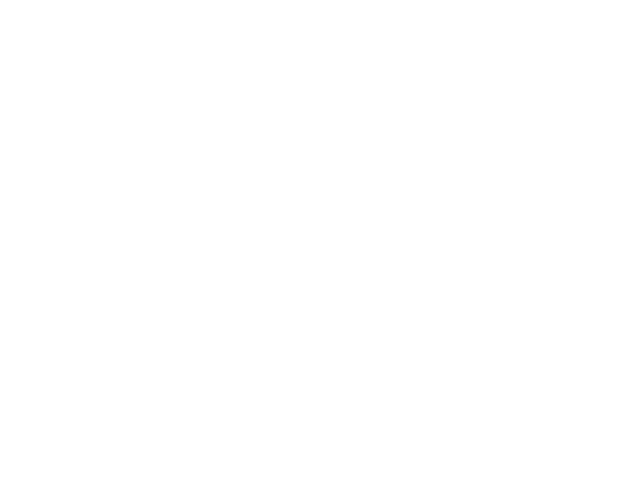

<IPython.core.display.Javascript object>


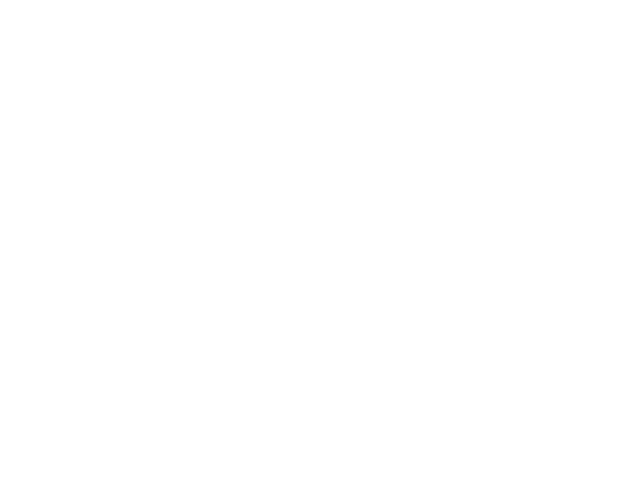

<IPython.core.display.Javascript object>


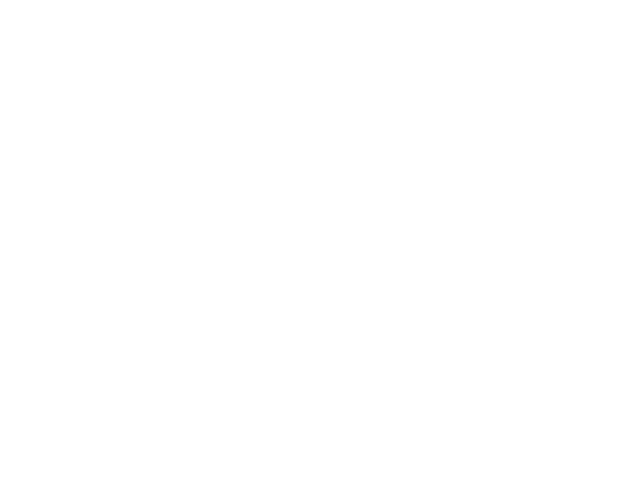

In [7]:
#Check Initial conditions
staticPlot(uEvol[0])
staticPlot(sinEvol[0])
staticPlot(uEvol[0]-sinEvol[0])

<IPython.core.display.Javascript object>


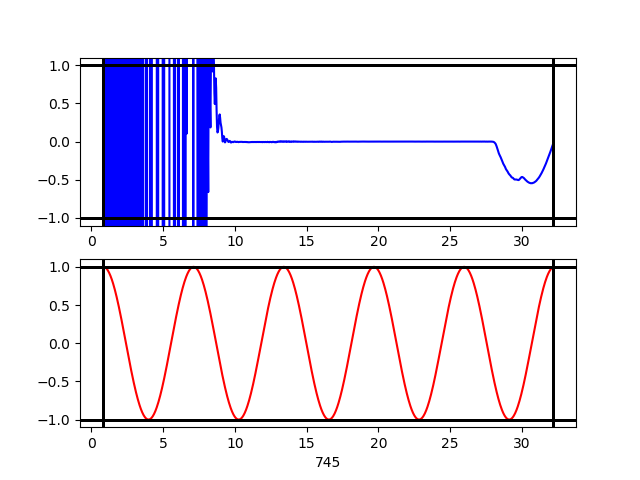

In [8]:
#Imports for visualization
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, (ax1, ax2) = plt.subplots(2)
line1, = ax1.plot(x, uEvol[0],'-b')
line2, = ax2.plot(x, sinEvol[0],'-r')

def animate(t):
    line1.set_ydata(uEvol[t])  # update the data
    line2.set_ydata(sinEvol[t])  # update the data
    ax2.set_xlabel(t)
    line1.ylabel(uEvol[t].max())
    line2.ylabel(sinEvol[t].max())
    return line,

# Init only required for blitting to give a clean slate.
def init():
    line1.set_ydata(uEvol[0])
    line2.set_ydata(sinEvol[0])
    ax1.axhline(1, color='black', lw=1)
    ax2.axhline(1, color='black', lw=1)
    ax1.axhline(-1, color='black', lw=1)
    ax2.axhline(-1, color='black', lw=1)
    ax1.axvline(0.25*np.pi, color='black', lw=1)
    ax2.axvline(0.25*np.pi, color='black', lw=1)
    ax1.axvline(10.25*np.pi, color='black', lw=1)
    ax2.axvline(10.25*np.pi, color='black', lw=1)
    return line1, line2

ani = animation.FuncAnimation(fig, animate, np.arange(t0, tmax), init_func=init,
                              interval=10, blit=True)
plt.show()

<IPython.core.display.Javascript object>


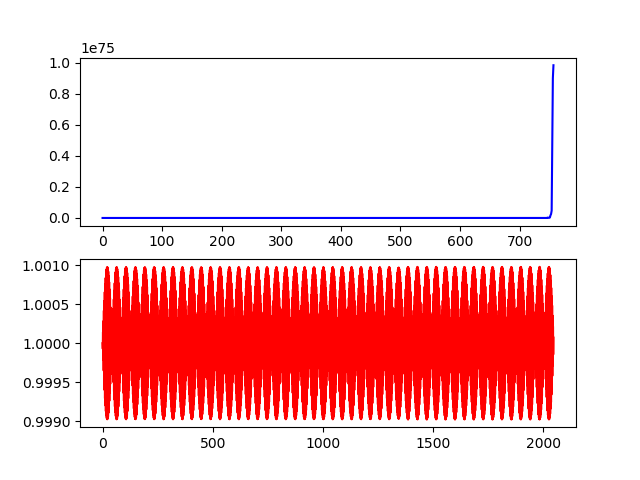

In [9]:
potEnergyTf   = np.asarray([sum([se**2 for se in SE]) for SE in uEvol])
potEnergyReal = np.asarray([sum([se**2 for se in SE]) for SE in sinEvol])


figEnergy, (axEnergyTf,axEnergyReal) = plt.subplots(2)
lineEtf, = axEnergyTf.plot(potEnergyTf/potEnergyTf[0],'-b')
lineEre, = axEnergyReal.plot(potEnergyReal/potEnergyReal[0], '-r')

plt.show()

In [10]:
print(max(potEnergyReal/potEnergyReal[0]))
print(max(potEnergyTf/potEnergyTf[0]))
#plt.plot(uEvol[0])
#plt.show()

1.000978761341211
inf


In [11]:
len(potEnergyReal)

2048